## 1. Requirements

In [1]:
import os
import random
import numpy as np
import pandas as pd
from math import sqrt
import tqdm

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
import matplotlib.pyplot as plt

## 2. Set Args

In [2]:
theta = 7
num_epochs = 500
dropout_ratio = 0.5

data_path = 'https://raw.githubusercontent.com/kw-lee/MIDA-pytorch/master/data/BostonHousing.csv'
mechanism = 'mcar'
method = 'uniform'

test_size = 0.3
use_cuda = True
batch_size  = 1 # not in the paper

## 3. Prepare Data

In [3]:
data = pd.read_csv(data_path).values

rows, cols = data.shape
shuffled_index = np.random.permutation(rows)
train_index = shuffled_index[:int(rows*(1-test_size))]
test_index = shuffled_index[int(rows*(1-test_size)):]

train_data = data[train_index, :]
test_data = data[test_index, :]

# standardized between 0 and 1
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [4]:
def missing_method(raw_data, mechanism='mcar', method='uniform') :
    
    data = raw_data.copy()
    rows, cols = data.shape
    
    # missingness threshold
    t = 0.2
    
    if mechanism == 'mcar' :
    
        if method == 'uniform' :
            # uniform random vector
            v = np.random.uniform(size=(rows, cols))

            # missing values where v<=t
            mask = (v<=t)
            data[mask] = 0

        elif method == 'random' :
            # only half of the attributes to have missing value
            missing_cols = np.random.choice(cols, cols//2)
            c = np.zeros(cols, dtype=bool)
            c[missing_cols] = True

            # uniform random vector
            v = np.random.uniform(size=(rows, cols))

            # missing values where v<=t
            mask = (v<=t)*c
            data[mask] = 0

        else :
            print("Error : There are no such method")
            raise
    
    elif mechanism == 'mnar' :
        
        if method == 'uniform' :
            # randomly sample two attributes
            sample_cols = np.random.choice(cols, 2)

            # calculate ther median m1, m2
            m1, m2 = np.median(data[:,sample_cols], axis=0)
            # uniform random vector
            v = np.random.uniform(size=(rows, cols))

            # missing values where (v<=t) and (x1 <= m1 or x2 >= m2)
            m1 = data[:,sample_cols[0]] <= m1
            m2 = data[:,sample_cols[1]] >= m2
            m = (m1*m2)[:, np.newaxis]

            mask = m*(v<=t)
            data[mask] = 0


        elif method == 'random' :
            # only half of the attributes to have missing value
            missing_cols = np.random.choice(cols, cols//2)
            c = np.zeros(cols, dtype=bool)
            c[missing_cols] = True

            # randomly sample two attributes
            sample_cols = np.random.choice(cols, 2)

            # calculate ther median m1, m2
            m1, m2 = np.median(data[:,sample_cols], axis=0)
            # uniform random vector
            v = np.random.uniform(size=(rows, cols))

            # missing values where (v<=t) and (x1 <= m1 or x2 >= m2)
            m1 = data[:,sample_cols[0]] <= m1
            m2 = data[:,sample_cols[1]] >= m2
            m = (m1*m2)[:, np.newaxis]

            mask = m*(v<=t)*c
            data[mask] = 0

        else :
            print("Error : There is no such method")
            raise
    
    else :
        print("Error : There is no such mechanism")
        raise
        
    return data, mask

In [5]:
missed_data, mask = missing_method(test_data, mechanism=mechanism, method=method)

missed_data = torch.from_numpy(missed_data).float()
train_data = torch.from_numpy(train_data).float()

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

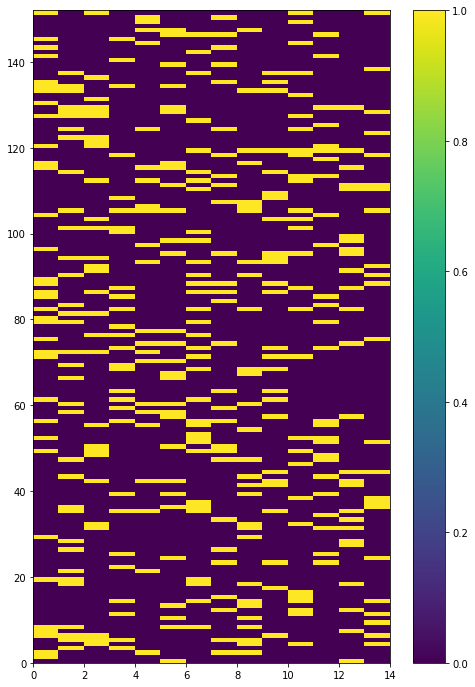

In [6]:
fig = plt.figure(figsize = (8, 12))
plt.pcolormesh(mask)
plt.colorbar()
plt.show()

## 4. Define Model

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
print(device)

cpu


In [9]:
class Autoencoder(nn.Module):
    def __init__(self, dim):
        super(Autoencoder, self).__init__()
        self.dim = dim
        
        self.drop_out = nn.Dropout(p=0.5)
        
        self.encoder = nn.Sequential(
            nn.Linear(dim+theta*0, dim+theta*1),
            nn.Tanh(),
            nn.Linear(dim+theta*1, dim+theta*2),
            nn.Tanh(),
            nn.Linear(dim+theta*2, dim+theta*3)
        )
            
        self.decoder = nn.Sequential(
            nn.Linear(dim+theta*3, dim+theta*2),
            nn.Tanh(),
            nn.Linear(dim+theta*2, dim+theta*1),
            nn.Tanh(),
            nn.Linear(dim+theta*1, dim+theta*0)
        )
        
    def forward(self, x):
        x = x.view(-1, self.dim)
        x_missed = self.drop_out(x)
        
        z = self.encoder(x_missed)
        out = self.decoder(z)
        
        out = out.view(-1, self.dim)
        
        return out

In [10]:
model = Autoencoder(dim=cols).to(device)

## 5. Define Loss and Optimizer

In [11]:
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

## 6. Train Model

In [12]:
cost_list = []
early_stop = False
t = tqdm.trange(num_epochs, desc='Epoch', leave=True)
for epoch in t:
    total_batch = len(train_data) // batch_size
    
    for i, batch_data in enumerate(train_loader):
        
        batch_data = batch_data.to(device)
        
        reconst_data = model(batch_data)
        cost = loss(reconst_data, batch_data)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()                

        # early stopping rule 1 : MSE < 1e-06
        if cost.item() < 1e-06 :
            early_stop = True
            break
            
#         early stopping rule 2 : simple moving average of length 5
#         sometimes it doesn't work well.
#         if len(cost_list) > 5 :
#            if cost.item() > np.mean(cost_list[-5:]):
#                early_stop = True
#                break
                
    cost_list.append(cost.item())
    t.set_postfix_str('Loss: %.6f' %(cost.item()))
    if early_stop :
        break
        
print("Learning Finished!")

Epoch: 100%|██████████| 500/500 [03:26<00:00,  2.42it/s, Loss: 0.082964]

Learning Finished!


## 7. Test Model

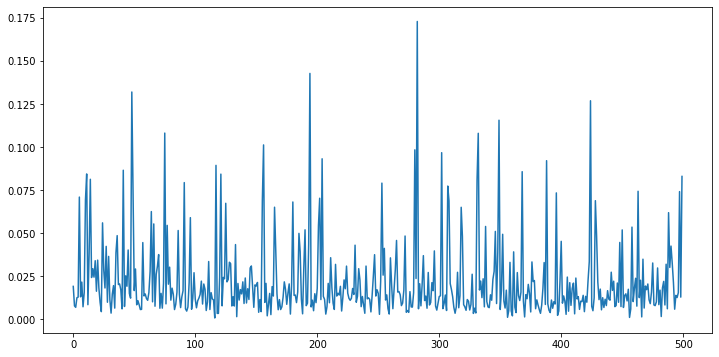

In [13]:
fig = plt.figure(figsize = (12, 6))
plt.plot(cost_list)
plt.show()

In [14]:
model.eval()
filled_data = model(missed_data.to(device))
filled_data = filled_data.cpu().detach().numpy()

rmse_sum = 0

for i in range(cols) :
    if mask[:,i].sum() > 0 :
        y_actual = test_data[:,i][mask[:,i]]
        y_predicted = filled_data[:,i][mask[:,i]]

        rmse = sqrt(mean_squared_error(y_actual, y_predicted))
        rmse_sum += rmse
    
print("RMSE_SUM :", rmse_sum)

RMSE_SUM : 3.4408480626745415


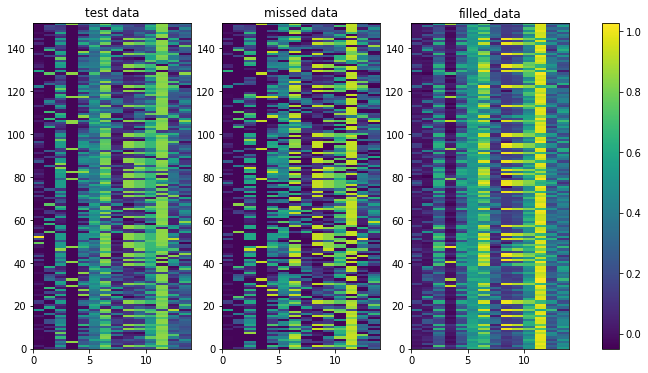

In [15]:
f, axs = plt.subplots(1,3, figsize=(12,6))
axs[0].pcolormesh(test_data)
axs[0].set_title("test data")
axs[1].pcolormesh(missed_data)
axs[1].set_title("missed data")
im = axs[2].pcolormesh(filled_data)
axs[2].set_title("filled_data")

fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()